# AUTOR

WALTER BUENO DE BRITO NETO => Matricula 105471

Professor, uma observação, o codigo está repetido principalmente nos benchmarks para gerar plots, por conta do tempo corrido não arrumei, mas pretendo generalizar.

O codigo foi rodado no meu pc que atualmente suporta mais de 1M, limitei a 1M por conta do tempo.

# DONWLOAD

In [ ]:
!pip install -q datasets
!pip install -q pyarrow
!pip install tqdm
!pip install -q huggingface_hub
!pip install matplotlib

^C


# IMPORTS

In [ ]:
import numpy as np
from typing import List, Dict
import heapq
import time
from datasets import Dataset
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import glob
import time
import random
random.seed(42)
np.random.seed(42)

c:\Users\dracb\anaconda3\envs\rag_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BAIXAR EMBEDDINGS

In [ ]:
!huggingface-cli download marquesafonso/wikipedia-pt-embeddings \
    --repo-type dataset \
    --local-dir wikipedia_pt

^C


In [ ]:
from datasets import load_dataset

ds = load_dataset(
    "parquet",
    data_dir=r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data",
    split="train",
    streaming=True
)

In [7]:
for row in ds.take(4):
    print(row["title"])
    print(row["embeddings"][:10])
    print(len(row["embeddings"]))

Astronomia
[0.0212602186948061, 1.1849733591079712, -2.5951857566833496, 0.6565386652946472, -2.593024253845215, 0.9220377206802368, 1.6272355318069458, 1.86875319480896, -0.3669195771217346, -0.5113182663917542]
256
Astronomia
[0.25981926918029785, 0.5820974111557007, -1.508709192276001, 0.9858999848365784, 0.11289810389280319, -0.4957168400287628, 0.17866645753383636, 2.8199374675750732, -1.7678769826889038, -2.1046488285064697]
256
Astronomia
[0.13556230068206787, 0.331262469291687, -1.3611034154891968, -0.8760878443717957, -2.0587880611419678, -0.40477174520492554, 0.8794429898262024, 1.3537800312042236, -1.3414000272750854, -0.4922139346599579]
256
Astronomia
[-0.7249560356140137, -0.2758815884590149, -2.069847345352173, 0.26036176085472107, -1.3741731643676758, 0.5435667634010315, 0.3515881896018982, 2.4588541984558105, -2.5620810985565186, 0.372840940952301]
256


# UTILS

In [ ]:
def batch_iter(dataset, batch_size=1000):
    batch = []
    for row in dataset:
        batch.append(row["embeddings"])
        if len(batch) == batch_size:
            yield np.array(batch)
            batch = []
    if batch:
        yield np.array(batch)
        

def make_subset_fast(path, N):
    subset = []

    shards = sorted(glob.glob(f"{path}/*.parquet"))

    for shard_file in shards:
        table = pq.read_table(shard_file, columns=["embeddings"])
        batch = table["embeddings"].to_pylist()

        for emb in batch:
            subset.append(np.array(emb, dtype=np.float32))
            if len(subset) >= N:
                return subset

    return subset

def batch_generator_from_list(data, batch_size=1024):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

Aqui nesse teste de exaustao, o colab nao chega aos 1M

In [ ]:
# Teste de exaustao
path = r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data"
tam_emb = [1_000, 10_000, 100_000, 500_000, 1_000_000, 2_000_000]

for N in tam_emb:
    subset = make_subset_fast(path, N)

#MOTIVAÇÂO DO PROBLEMA


A minha motivação veio em tentar unir 2 trabalhos em um somente, além da matéria de ED, estou fazendo uma matéria de RAG(Retrieval Augmentation Generation), uma das etapas do RAG como mostrado abaixo é que existe uma fase de busca no banco de dados, eu fiquei curioso pois o FAISS/ChromaDB implementao o tipo de busca vetorial por baixo dos panos, entao decide que queria tentar explorar mais a fundo sobre esse tipo de algoritmos, desse modo decidi que queria explorar mais a fundo esse campo. Me arrependo de certa forma pois é bem complexo.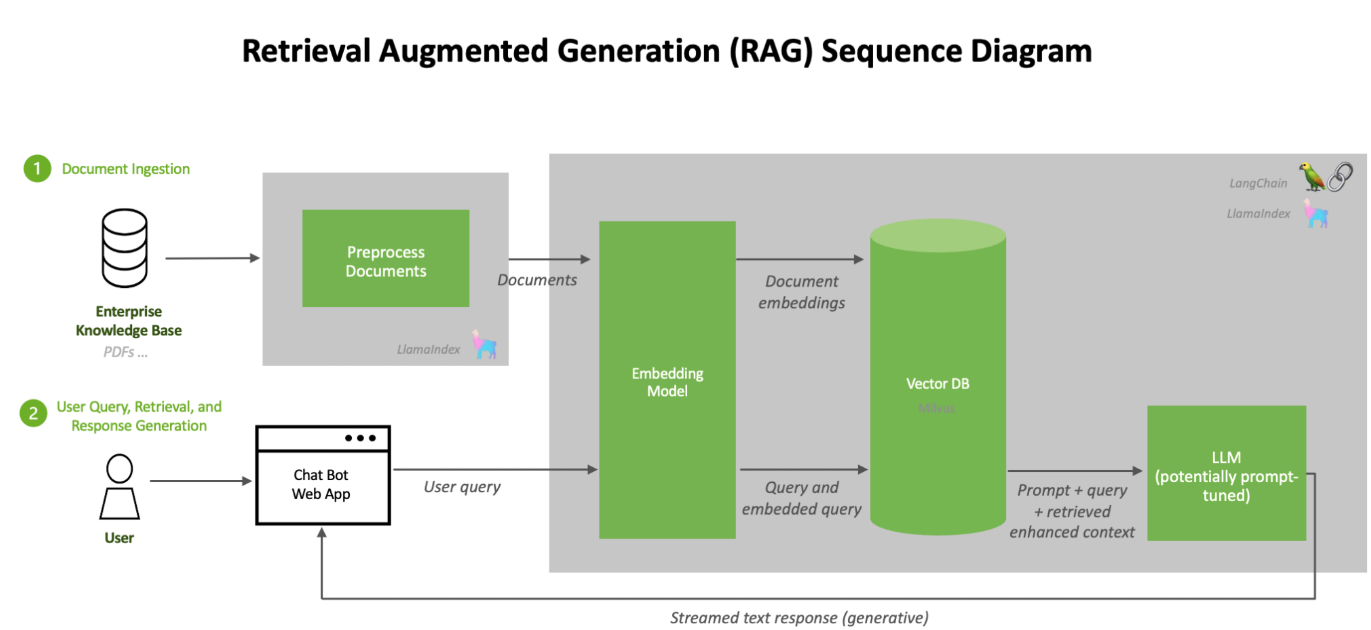

# KNN

O KNN(K-Nearest Neighbor) é um algoritmo usado para classificação e regressao en que é podemos dividir em 3 fases:

i)Calcula a distancia de um ponto em relaçao a todos os outros

ii) Ordena em relaçao a menor distancia e pega o k mais proximos

iii) Vota baseado no labels do k vizinhos


No meu caso eu faço apenas até a 2 fase, dado que quero os k vetores de embeddings mais proximos do meu vetor query embedding.

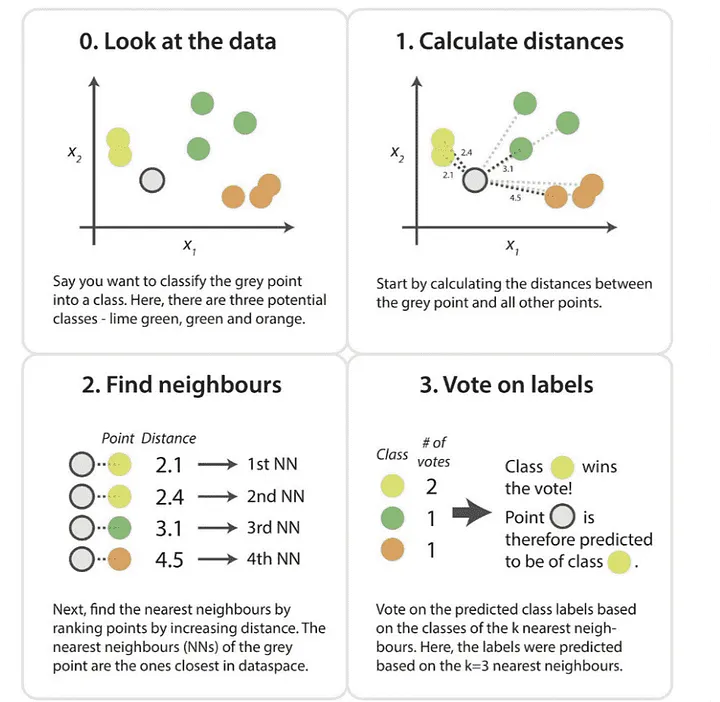

O algoritmo KNN tradicional não possui fase de treinamento.  
Toda a complexidade está concentrada na fase de busca.

Para cada vetor computamos a distância Euclidiana:

$$
d(\mathbf{q}, \mathbf{x}_i) = \sqrt{\sum_{j=1}^{d} (q_j - x_{i,j})^2}
$$

Esse custo é proporcional à dimensionalidade.

Como existem n vetores, o custo total do cálculo das distâncias é:

$$
O(n \cdot d)
$$

Depois de calcular as n distâncias, precisamos selecionar os k menores valores.

Custo:
$$
O(n \log n)
$$


Com o uso de heap, cada inserção ou troca custa O(log k), logo:

$$
O(n \log k)
$$

Como normalmente k < n, esta abordagem é mais rápida.

Usando heap:

$$
O(n \cdot d + n \log k)
$$

Para embeddings, onde d é fixo e pequeno comparado a n, e k é muito menor que n:

$$
O(n \cdot d)
$$

Ou seja, o KNN tradicional tem complexidade linear no número de pontos.  
Por isso, métodos como LSH, HNSW e FAISS são necessários para bases grandes.


In [9]:
class NaiveKNN:
    def __init__(self, k: int = 5):
        self.k = k

    def search(self, query_embedding: np.ndarray, embeddings: List[np.ndarray]) -> Dict:

        result = []
        total_distancias = 0
        total_ops = 0
        D = len(query_embedding)

        for idx, emb in enumerate(embeddings):
            dist = np.linalg.norm(query_embedding - emb)
            total_distancias += 1
            total_ops += D
            result.append((dist, idx))

        knn_heap = heapq.nsmallest(self.k, result, key=lambda x: x[0])
        knn_indices = [idx for _, idx in knn_heap]

        return {
            "knn": knn_indices,
            "distancias_calculadas": total_distancias,
            "operacoes_estimadas": total_ops
        }


def benchmark_KNN(path = r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data", sizes=[1_000, 10_000, 100_000, 500_000, 1_000_000, 2_000_000]):
    results = []
    knn = NaiveKNN(k=5)

    for N in sizes:
        print(f"\n=== Rodando benchmark para {N:,} embeddings ===")

        start_time = time.time()
        subset = make_subset_fast(path, N)
        end_time = time.time()
        
        print(f"Tempo para carregar subset: {end_time - start_time:.2f} s")

        query = subset[np.random.randint(0, len(subset))]

        print(f"Tamanho do Embedding: {len(query)}")

        start = time.time()
        metrics = knn.search(query, subset)
        end = time.time()

        results.append({
            "N": N,
            "tempo_segundos": end - start,
            "distancias": metrics["distancias_calculadas"],
            "ops": metrics["operacoes_estimadas"]
        })

    return results

def plot_knn_metrics(results):
    Ns = [r["N"] for r in results]
    tempos = [r["tempo_segundos"] for r in results]
    ops = [r["ops"] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(Ns, tempos, marker='o', color='blue')
    plt.xlabel("Número de embeddings")
    plt.ylabel("Tempo (s)")
    plt.title("Tempo x Tamanho do Dataset")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(Ns, ops, marker='o', color='red')
    plt.xlabel("Número de embeddings")
    plt.ylabel("Operações estimadas")
    plt.title("Operações x Tamanho do Dataset")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [6]:
results_knn = benchmark_KNN()


=== Rodando benchmark para 1,000 embeddings ===
Tempo para carregar subset: 14.61 s
Tamanho do Embedding: 256

=== Rodando benchmark para 10,000 embeddings ===
Tempo para carregar subset: 14.78 s
Tamanho do Embedding: 256

=== Rodando benchmark para 100,000 embeddings ===
Tempo para carregar subset: 15.78 s
Tamanho do Embedding: 256

=== Rodando benchmark para 500,000 embeddings ===
Tempo para carregar subset: 63.89 s
Tamanho do Embedding: 256

=== Rodando benchmark para 1,000,000 embeddings ===
Tempo para carregar subset: 127.91 s
Tamanho do Embedding: 256

=== Rodando benchmark para 2,000,000 embeddings ===
Tempo para carregar subset: 244.89 s
Tamanho do Embedding: 256


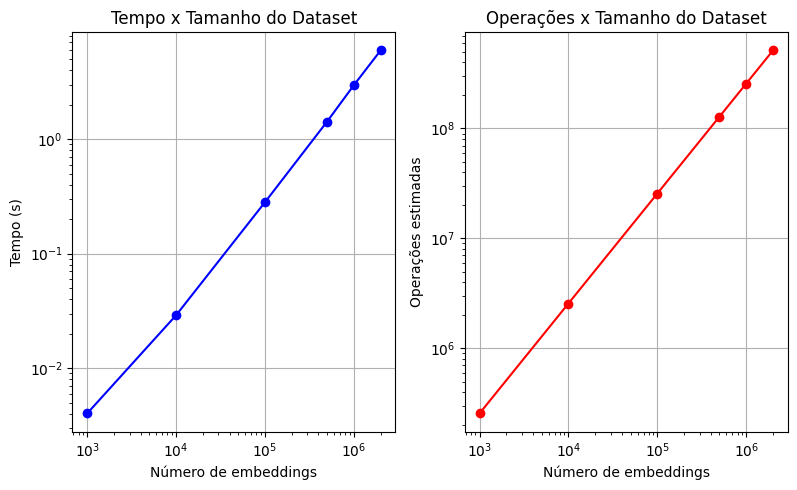

In [7]:
plot_knn_metrics(results_knn)

# Locality Sensitive Hashing (LSH)

## EXPLICAÇÃO GERAL DO LSH

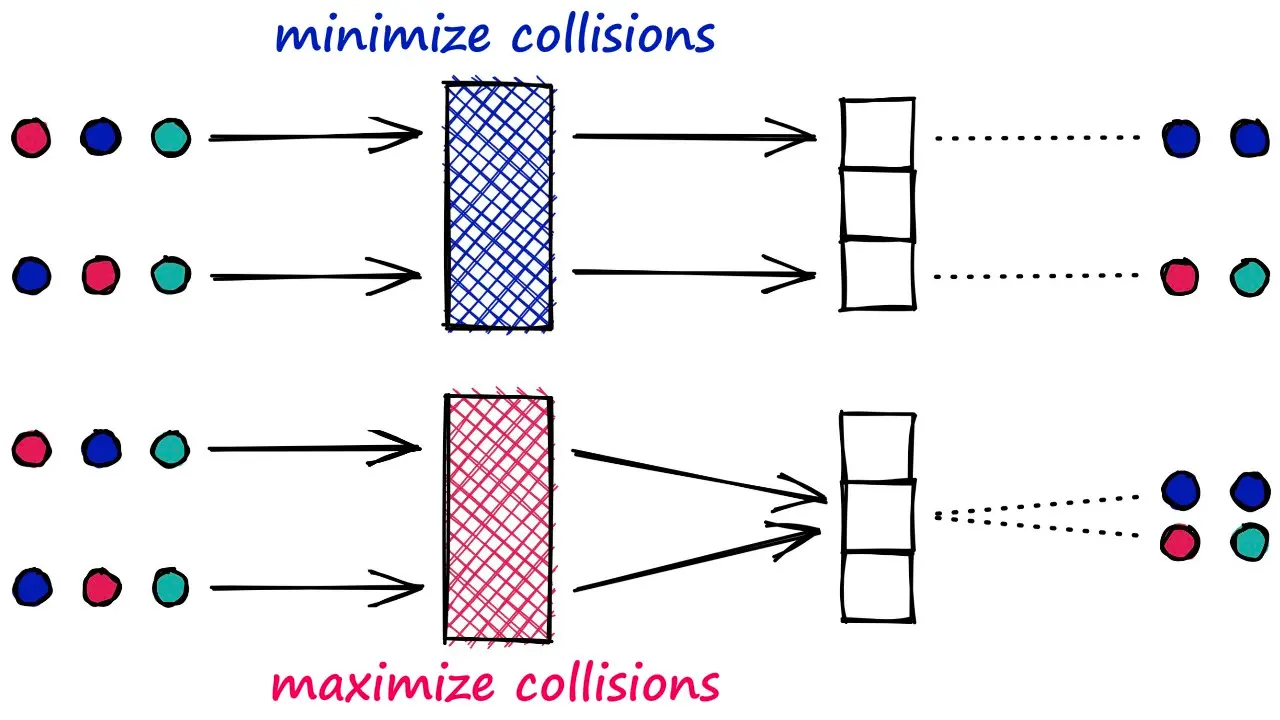

Quando usamos tabela Hash queremos sempre tentar evitar colisão, no caso do LSH a ideia é maximizar colisões de vetores semanticamente parecidos e minimizar colisao de vetores diferentes.

Efetuar uma busca utilizando LSH envolve três passos principais:

i) Hashing dos vetores do conjunto: todos os embeddings são convertidos para suas assinaturas hash e organizados em buckets.

ii) Hashing da consulta: o vetor de consulta é projetado pelos mesmos hiperplanos e recebe sua assinatura hash correspondente.

iii) Busca por similaridade: a assinatura hash da consulta é comparada às existentes, usando a distância de Hamming para identificar os buckets mais semelhantes e recuperar os vetores semelhantes.

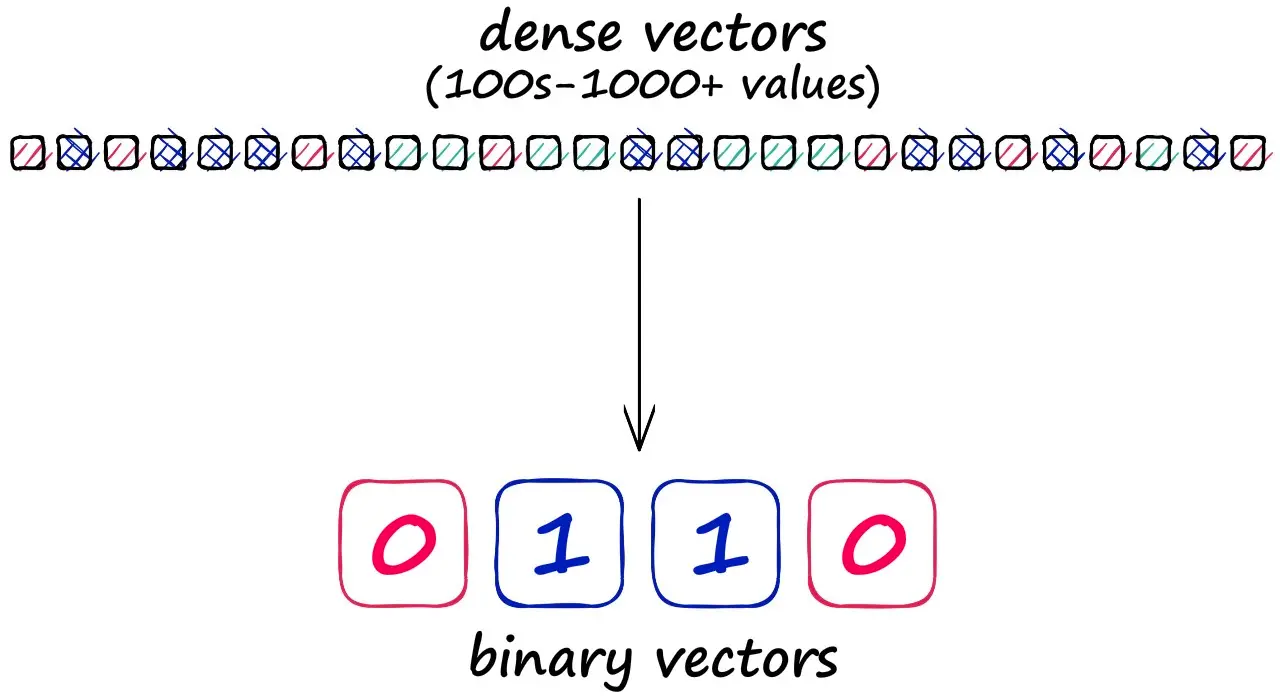

Existem diversas variações do método LSH, cada uma baseada em diferentes estratégias de geração de hashes e métricas de similaridade. Entre as abordagens mais utilizadas destacam-se:

i) Shingling combinado com MinHashing, aplicado principalmente em detecção de similaridade entre documentos.

ii) Projeções por hiperplanos aleatórios, que utilizam produtos escalares para gerar assinaturas binárias e avaliam similaridade por meio da distância de Hamming.

A ideia por trás do uso de hiperplanos é que, ao calcularmos o produto escalar entre o vetor normal do hiperplano e um embedding, o sinal do resultado indica de que lado do hiperplano o vetor está. O valor pode ser positivo ou negativo, correspondendo às duas regiões definidas pelo hiperplano (lado + e lado –). Essa propriedade permite transformar cada embedding em um bit: 1 para valores positivos e 0 para valores negativos.


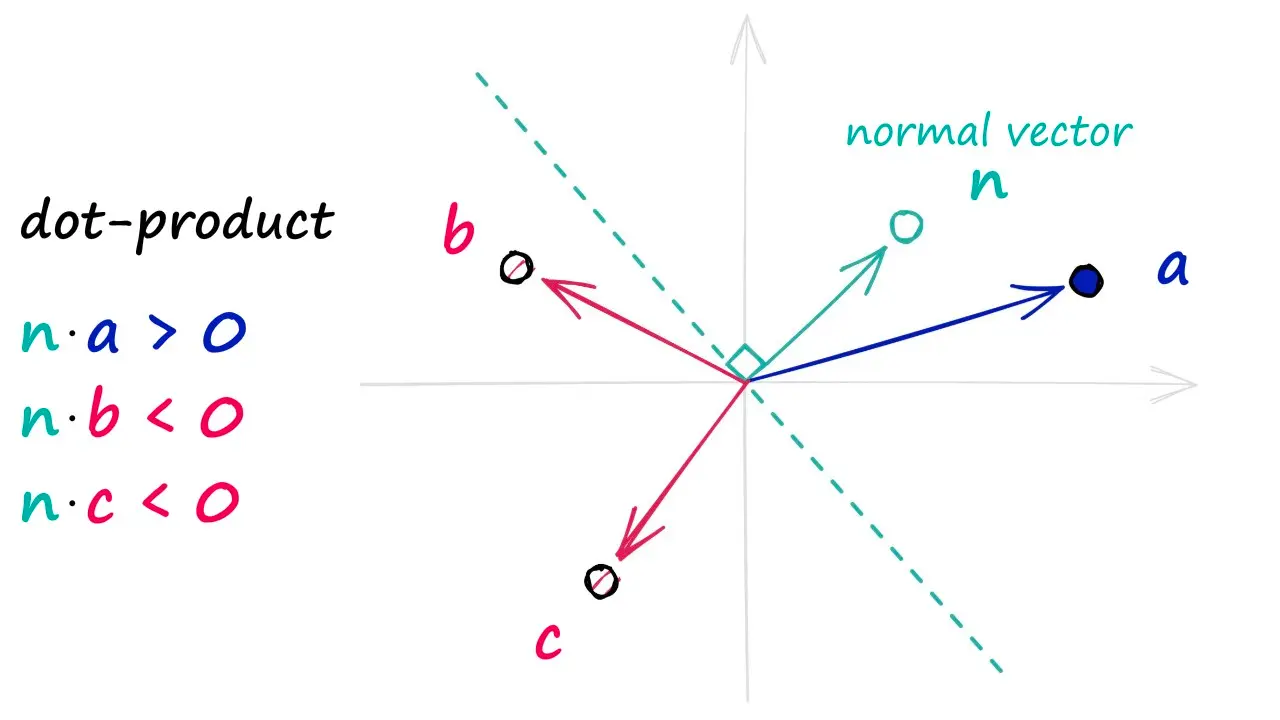

Dessa forma, os bits de cada embedding podem ser calculados por meio da expressão
(np.dot(self.hyper_planes, embedding) >= 0).astype(np.uint8),
que atribui 1 aos vetores que ficam no lado positivo do hiperplano e 0 aos que ficam no lado negativo.
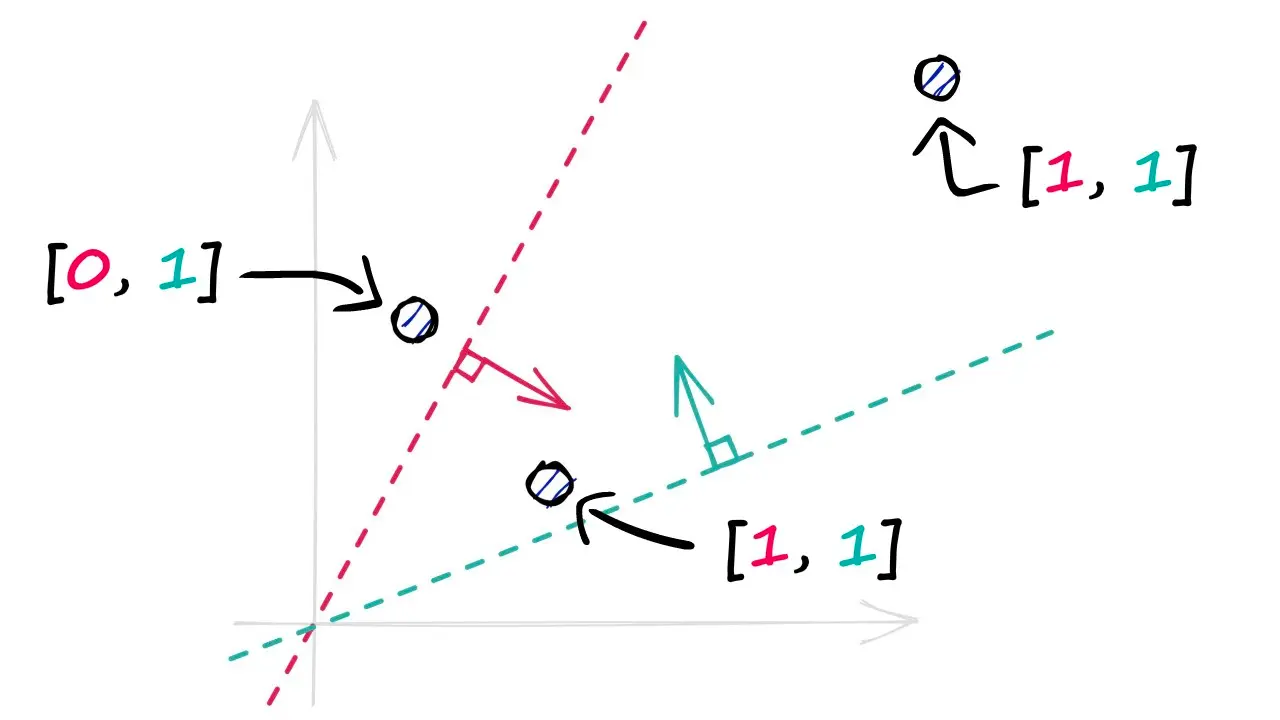

## Custo da Construção e Consulta do LSH com L Tabelas

Custo da Construção

Para construir os buckets com L tabelas, para cada embedding:

Como adicionar em um bucket é O(1), o custo por embedding por tabela é:
$$
O(L \cdot \text{num\_hashes} \cdot \text{dim})
$$
Portanto, para todos os embeddings e todas as tabelas, o custo total da construção do índice é:

$$
O(n \cdot L \cdot \text{num\_hashes} \cdot \text{dim})
$$


Onde n é o número de embeddings. Para conjuntos grandes, normalmente n >> num_hashes * dim * L, então podemos aproximar:

$$
O(n)
$$

Custo da Consulta (Search)

Gerar a assinatura da query para cada tabela:

$$
O(L \cdot \text{num\_hashes} \cdot \text{dim})
$$

Buscar candidatos nos buckets correspondentes em todas as tabelas:

- Se `num_hashes` é pequeno: poucos buckets → cada bucket é grande → muitos candidatos → recall maior, mas consulta mais lenta.  
- Se `num_hashes` é grande: muitos buckets → buckets pequenos → consulta rápida, mas recall pode ser baixo.  
- Com L tabelas, mesmo que uma tabela tenha buckets muito fragmentados, outras tabelas podem capturar vizinhos próximos, aumentando o recall.

Re-ranking dos candidatos (distâncias):

$$
O(C \cdot \text{dim})
$$

Onde C é o número total de candidatos coletados de todas as tabelas.

Observações

- Trade-off: Aumentar `num_hashes` reduz o tamanho médio dos buckets, acelerando consultas, mas pode reduzir recall.  
- Multi-table (L > 1): melhora recall sem precisar aumentar muito o tamanho dos buckets, pois cada tabela oferece uma chance adicional de capturar vizinhos.  
- A consulta continua sendo muito mais rápida que KNN exato, pois processa apenas os candidatos dos buckets selecionados.


## IMPLEMENTAÇAO COM L TABELAS

In [10]:
import numpy as np
from typing import List, Dict

class LSH_MultiTable:
    def __init__(self, num_hashes: int = 10, dim: int = 256, L: int = 5):
        self.L = L
        self.num_hashes = num_hashes
        self.dim = dim

        self.hyper_planes = [np.random.standard_normal((num_hashes, dim)) for _ in range(L)]
        self.buckets: List[Dict[tuple, List[int]]] = [{} for _ in range(L)]

    def signature(self, embedding: np.ndarray, table_idx: int) -> np.ndarray:
        return (np.dot(self.hyper_planes[table_idx], embedding) >= 0).astype(np.uint8)

    def add_embeddings(self, embeddings: List[np.ndarray]):
        for idx, emb in enumerate(embeddings):
            for t in range(self.L):
                sig_key = tuple(self.signature(emb, t).tolist())
                if sig_key not in self.buckets[t]:
                    self.buckets[t][sig_key] = []
                self.buckets[t][sig_key].append(idx)

    def add_batch_embeddings(self, batch_embeddings: np.ndarray):
        for i, emb in enumerate(batch_embeddings):
            for t in range(self.L):
                sig_key = tuple(self.signature(emb, t).tolist())
                if sig_key not in self.buckets[t]:
                    self.buckets[t][sig_key] = []
                self.buckets[t][sig_key].append(i)

    def search(self, query_embedding: np.ndarray, embeddings: List[np.ndarray], k: int = 5) -> List[int]:

        candidates_set = set()
        for t in range(self.L):
            query_sig = tuple(self.signature(query_embedding, t).tolist())
            candidates_set.update(self.buckets[t].get(query_sig, []))

        if not candidates_set:
            return []

        distances = []
        for idx in candidates_set:
            dist = np.linalg.norm(query_embedding - embeddings[idx])
            distances.append((idx, dist))

        distances.sort(key=lambda x: x[1])
        return [idx for idx, _ in distances[:k]]


In [11]:
def benchmark_LSH_multi_table(
    path=r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data",
    sizes=[1_000, 10_000, 100_000, 1_000_000, 2_000_000],
    num_hashes=10,
    L=5,
    k=5
):

    for N in sizes:
        print(f"\n=== Rodando benchmark para {N:,} embeddings ===")

        start_time = time.time()
        subset = make_subset_fast(path, N)
        end_time = time.time()
        print(f"Tempo para carregar subset: {end_time - start_time:.2f} s")

        query = subset[np.random.randint(0, len(subset))]
        print(f"Tamanho do Embedding: {len(query)}")

        lsh = LSH_MultiTable(num_hashes=num_hashes, dim=len(query), L=L)

        start_constr = time.time()
        lsh.add_embeddings(subset)
        end_constr = time.time()
        print(f"Tempo para construir LSH com {L} tabelas: {end_constr - start_constr:.2f} s")

        start_search = time.time()
        retrieved = lsh.search(query, subset, k=k)
        end_search = time.time()
        print(f"Tempo consulta LSH: {end_search - start_search:.4f} s")
        print(f"Candidates retornados: {len(retrieved)}")

        gt = top_k_ground_truth(query, subset, k=k)
        acertos = len(set(gt) & set(retrieved))
        recall = acertos / k

        print(f"Ground truth: {gt}")
        print(f"LSH retornou: {retrieved}")
        print(f"Recall@{k} = {recall:.2f}")



def benchmark_recall_vs_hashes_multi_table(
    path=r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data",
    N=1_000_000,
    hash_values=[4, 8, 16, 32, 64],
    L=5,
    k=5
):
    knn = NaiveKNN(k=k)
    print(f"Carregando {N:,} embeddings...")
    subset = make_subset_fast(path, N)
    query = subset[np.random.randint(0, len(subset))]
    dim = len(query)
    gt = knn.search(query, subset)['knn']

    recalls = []
    avg_bucket_sizes = []
    min_bucket_sizes = []
    max_bucket_sizes = []

    for num_hashes in hash_values:
        print(f"\n=== Testando num_hashes = {num_hashes}, L = {L} tabelas ===")
        lsh = LSH_MultiTable(num_hashes=num_hashes, dim=dim, L=L)

        start = time.time()
        lsh.add_embeddings(subset)
        print(f"Tempo construção LSH: {time.time() - start:.2f} s")

        all_bucket_sizes = []
        for b in lsh.buckets:
            sizes = [len(bucket) for bucket in b.values()]
            all_bucket_sizes.extend(sizes)

        avg_size = np.mean(all_bucket_sizes)
        min_size = np.min(all_bucket_sizes)
        max_size = np.max(all_bucket_sizes)

        avg_bucket_sizes.append(avg_size)
        min_bucket_sizes.append(min_size)
        max_bucket_sizes.append(max_size)

        retrieved = lsh.search(query, subset, k=k)
        acertos = len(set(gt) & set(retrieved))
        recall = acertos / k
        recalls.append(recall)

        print(f"Buckets totais (todas tabelas): {len(all_bucket_sizes):,}")
        print(f"Média de vetores por bucket: {avg_size:.2f}")
        print(f"Bucket mínimo: {min_size}")
        print(f"Bucket máximo: {max_size}")
        print(f"Recall@{k}: {recall:.3f}")

    return {
        "hash_values": hash_values,
        "recalls": recalls,
        "avg_bucket_sizes": avg_bucket_sizes,
        "min_bucket_sizes": min_bucket_sizes,
        "max_bucket_sizes": max_bucket_sizes,
    }


def plot_lsh_metrics_multi_table(results):
    hash_values = results["hash_values"]
    recalls = results["recalls"]
    avg_sizes = results["avg_bucket_sizes"]
    min_sizes = results["min_bucket_sizes"]
    max_sizes = results["max_bucket_sizes"]

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.plot(hash_values, recalls, marker='o', color='blue')
    plt.xlabel("Número de hashes (num_hashes)")
    plt.ylabel("Recall@K")
    plt.title("Recall x Número de Hashes")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(hash_values, avg_sizes, marker='o', color='green')
    plt.xlabel("Número de hashes (num_hashes)")
    plt.ylabel("Média de vetores por bucket")
    plt.title("Média de vetores por bucket x Número de Hashes")
    plt.yscale('log')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(hash_values, min_sizes, marker='o', label="Min", color='red')
    plt.plot(hash_values, max_sizes, marker='o', label="Max", color='orange')
    plt.xlabel("Número de hashes (num_hashes)")
    plt.ylabel("Tamanho dos buckets")
    plt.title("Min/Max vetores por bucket x Número de Hashes")
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [54]:
benchmark_LSH_multi_table(L = 1)


=== Rodando benchmark para 1,000 embeddings ===
Tempo para carregar subset: 16.16 s
Tamanho do Embedding: 256
Tempo para construir LSH com 1 tabelas: 0.00 s
Tempo consulta LSH: 0.0015 s
Candidates retornados: 4
Ground truth: [685, 684, 686, 687, 680]
LSH retornou: [685, 687, 690, 47]
Recall@5 = 0.40

=== Rodando benchmark para 10,000 embeddings ===
Tempo para carregar subset: 15.20 s
Tamanho do Embedding: 256
Tempo para construir LSH com 1 tabelas: 0.04 s
Tempo consulta LSH: 0.0000 s
Candidates retornados: 5
Ground truth: [3685, 3684, 3686, 3677, 3680]
LSH retornou: [3685, 9551, 9139, 6489, 9900]
Recall@5 = 0.20

=== Rodando benchmark para 100,000 embeddings ===
Tempo para carregar subset: 17.84 s
Tamanho do Embedding: 256
Tempo para construir LSH com 1 tabelas: 0.46 s
Tempo consulta LSH: 0.0025 s
Candidates retornados: 5
Ground truth: [33359, 45748, 32625, 21599, 52807]
LSH retornou: [33359, 45068, 39732, 56070, 27909]
Recall@5 = 0.20

=== Rodando benchmark para 1,000,000 embeddings 

In [55]:
benchmark_LSH_multi_table(L = 5)


=== Rodando benchmark para 1,000 embeddings ===
Tempo para carregar subset: 15.34 s
Tamanho do Embedding: 256
Tempo para construir LSH com 5 tabelas: 0.02 s
Tempo consulta LSH: 0.0000 s
Candidates retornados: 5
Ground truth: [416, 659, 408, 866, 399]
LSH retornou: [416, 588, 393, 322, 353]
Recall@5 = 0.20

=== Rodando benchmark para 10,000 embeddings ===
Tempo para carregar subset: 14.85 s
Tamanho do Embedding: 256
Tempo para construir LSH com 5 tabelas: 0.18 s
Tempo consulta LSH: 0.0005 s
Candidates retornados: 5
Ground truth: [8344, 8345, 8343, 5773, 7019]
LSH retornou: [8344, 8345, 7019, 9655, 1449]
Recall@5 = 0.60

=== Rodando benchmark para 100,000 embeddings ===
Tempo para carregar subset: 16.03 s
Tamanho do Embedding: 256
Tempo para construir LSH com 5 tabelas: 1.76 s
Tempo consulta LSH: 0.0095 s
Candidates retornados: 5
Ground truth: [19171, 74959, 46954, 17712, 79123]
LSH retornou: [19171, 16948, 26914, 46306, 85389]
Recall@5 = 0.20

=== Rodando benchmark para 1,000,000 embed

L = 1:

  - Muito rápido

  - Poucos candidatos

  - Recall baixo/médio (0.20–0.40)

  - Alta variância entre execuções e tamanhos de N

L = 5:

  - Continua rápido

  - Mais candidatos (porque busca em 5 tabelas)

  - Recall mais estável e tipicamente maior

Comparação L = 1 vs L = 5

Os experimentos mostram claramente que o LSH com apenas uma tabela (L = 1) é muito rápido, mas apresenta recall baixo e instável, pois depende inteiramente de uma única colisão de hash. Já a versão com múltiplas tabelas (L = 5) aumenta ligeiramente o custo de construção, mas mantém o tempo de consulta extremamente baixo, ao mesmo tempo em que melhora a recuperação dos vizinhos verdadeiros.

Em grande escala, a diferença prática é:

- L = 1: rápido, porém com buckets pequenos ou muito desbalanceados, resultando em poucos candidatos e baixa precisão.
- L = 5: aumenta a redundância da busca, gera mais candidatos relevantes e melhora o recall, ainda mantendo consultas na faixa de milissegundos.

Assim, para aplicações reais onde precisão importa, usar múltiplas tabelas é claramente vantajoso e continua muito eficiente.


Carregando 1,000,000 embeddings...

=== Testando num_hashes = 4, L = 1 tabelas ===
Tempo construção LSH: 3.66 s
Buckets totais (todas tabelas): 16
Média de vetores por bucket: 62500.00
Bucket mínimo: 13213
Bucket máximo: 179013
Recall@5: 0.200

=== Testando num_hashes = 8, L = 1 tabelas ===
Tempo construção LSH: 3.87 s
Buckets totais (todas tabelas): 256
Média de vetores por bucket: 3906.25
Bucket mínimo: 198
Bucket máximo: 29676
Recall@5: 0.400

=== Testando num_hashes = 16, L = 1 tabelas ===
Tempo construção LSH: 4.65 s
Buckets totais (todas tabelas): 55,703
Média de vetores por bucket: 17.95
Bucket mínimo: 1
Bucket máximo: 7268
Recall@5: 0.200

=== Testando num_hashes = 32, L = 1 tabelas ===
Tempo construção LSH: 6.63 s
Buckets totais (todas tabelas): 897,751
Média de vetores por bucket: 1.11
Bucket mínimo: 1
Bucket máximo: 492
Recall@5: 0.200

=== Testando num_hashes = 64, L = 1 tabelas ===
Tempo construção LSH: 7.77 s
Buckets totais (todas tabelas): 989,695
Média de vetores por bu

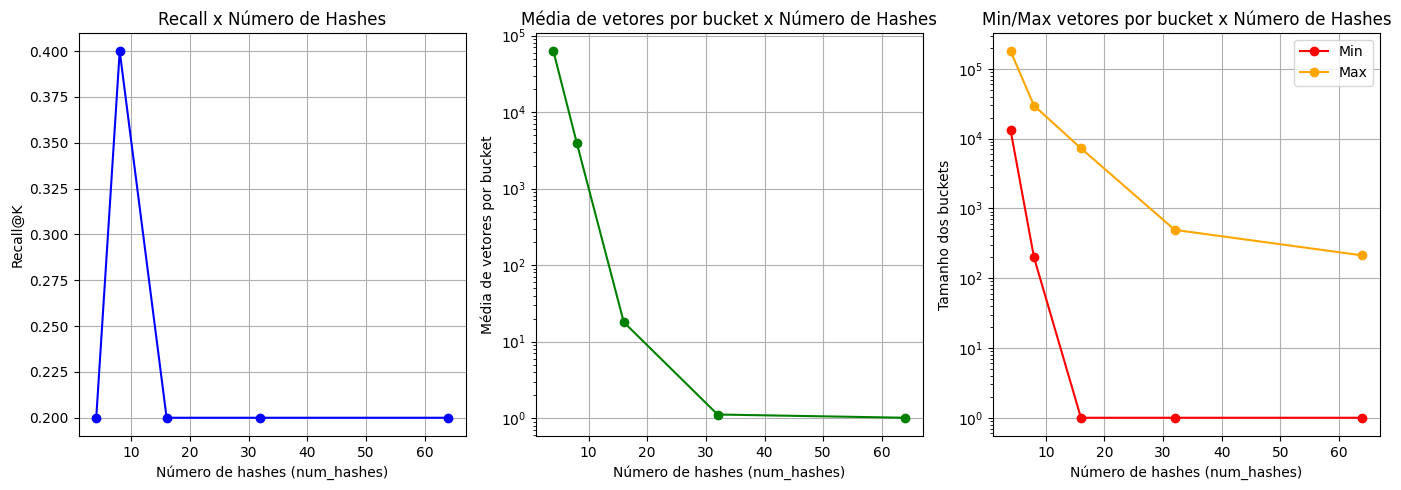

In [56]:
re = benchmark_recall_vs_hashes_multi_table( L = 1)
plot_lsh_metrics_multi_table(re)

Carregando 1,000,000 embeddings...

=== Testando num_hashes = 4, L = 5 tabelas ===
Tempo construção LSH: 16.59 s
Buckets totais (todas tabelas): 80
Média de vetores por bucket: 62500.00
Bucket mínimo: 7544
Bucket máximo: 318671
Recall@5: 0.800

=== Testando num_hashes = 8, L = 5 tabelas ===
Tempo construção LSH: 17.54 s
Buckets totais (todas tabelas): 1,280
Média de vetores por bucket: 3906.25
Bucket mínimo: 105
Bucket máximo: 57250
Recall@5: 1.000

=== Testando num_hashes = 16, L = 5 tabelas ===
Tempo construção LSH: 20.82 s
Buckets totais (todas tabelas): 296,275
Média de vetores por bucket: 16.88
Bucket mínimo: 1
Bucket máximo: 8913
Recall@5: 0.400

=== Testando num_hashes = 32, L = 5 tabelas ===
Tempo construção LSH: 30.91 s
Buckets totais (todas tabelas): 4,493,244
Média de vetores por bucket: 1.11
Bucket mínimo: 1
Bucket máximo: 2005
Recall@5: 0.200

=== Testando num_hashes = 64, L = 5 tabelas ===
Tempo construção LSH: 39.30 s
Buckets totais (todas tabelas): 4,955,314
Média de ve

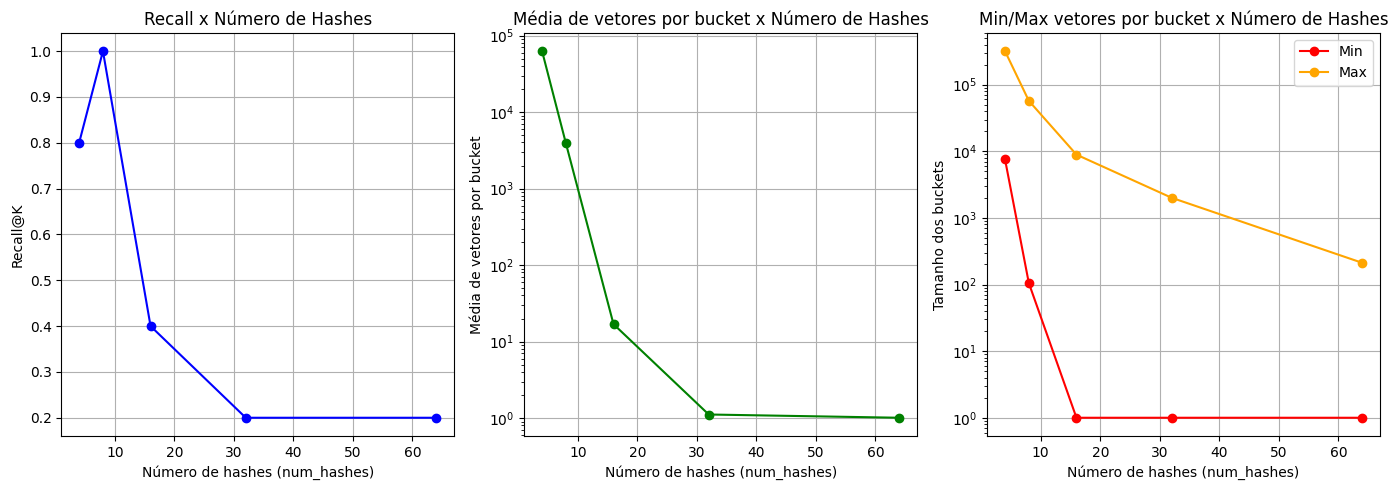

In [57]:
re = benchmark_recall_vs_hashes_multi_table( L = 5)
plot_lsh_metrics_multi_table(re)

Com L = 5, o recall explode para 0.8 e 1.0 quando num_hashes = 4 ou 8, algo impossível com L = 1.

O comportamento clássico do LSH é confirmado:

  - Poucos hashes → buckets grandes → recall maior.

  - Muitos hashes → buckets pequenos → recall cai para 0.2 novamente.

  - L = 5 diminui a sensibilidade ao valor de num_hashes, aumentando a probabilidade de colisão com vizinhos reais.

  - O tempo de construção com L=5 é ~5× maior (como esperado), mas permanece aceitável (16–40s para 1M embeddings).

Comparação entre L = 1 e L = 5 para 1.000.000 embeddings

| num_hashes | L | Tempo Build | Buckets Totais | Média por Bucket | Bucket Min | Bucket Max | Recall@5 |
|-----------:|---|-------------|----------------|------------------|------------|------------|----------|
| 4  | 1 | 3.66 s | 16        | 62500.00 | 13213 | 179013 | 0.20 |
| 4  | 5 | 16.59 s | 80       | 62500.00 | 7544  | 318671 | **0.80** |
| 8  | 1 | 3.87 s | 256       | 3906.25 | 198   | 29676  | 0.40 |
| 8  | 5 | 17.54 s | 1,280    | 3906.25 | 105   | 57250  | **1.00** |
| 16 | 1 | 4.65 s | 55,703    | 17.95   | 1     | 7268   | 0.20 |
| 16 | 5 | 20.82 s | 296,275  | 16.88   | 1     | 8913   | 0.40 |
| 32 | 1 | 6.63 s | 897,751   | 1.11    | 1     | 492    | 0.20 |
| 32 | 5 | 30.91 s | 4,493,244| 1.11    | 1     | 2005   | 0.20 |
| 64 | 1 | 7.77 s | 989,695   | 1.01    | 1     | 212    | 0.20 |
| 64 | 5 | 39.30 s | 4,955,314| 1.01    | 1     | 212    | 0.20 |


# HNSW

## Construção do Grafo HNSW

Os criadores do HNSW descobriram que o melhor desempenho ocorre quando minimizamos a sobreposição de vizinhos compartilhados entre as camadas. Reduzir o valor de m_L ajuda a diminuir essa sobreposição, empurrando mais vetores para a camada 0, mas isso aumenta o número médio de travessias durante a busca. Por isso, escolhe-se um valor de m_L que equilibre esses dois efeitos. Uma regra prática para esse valor é 1/ln(M).

## Fase 1 :Construção inicial

A construção do grafo começa na camada superior. Ao entrar no grafo, o algoritmo percorre as arestas de forma gulosa, encontrando os 'ef' vizinhos mais próximos do vetor que será inserido, 'q', 'ef = 1'.

Quando encontra o mínimo local, o algoritmo desce para a próxima camada, repetindo esse processo até atingir a camada de inserção do vetor. É nessa etapa que começa a segunda fase da construção.

## Fase 2: Inserção detalhada

Nesta fase, o valor de 'ef' é aumentado para 'efConstruction', permitindo que mais vizinhos próximos sejam considerados. Esses vizinhos se tornam candidatos a formar conexoes com o novo vetor 'q' e também servem como 'pontos de entrada' para a próxima camada.

Dos candidatos encontrados, 'M' vizinhos são escolhidos para criar as conexões(pegando os mais proximos).

## Busca 

Durante a busca, entramos na camada superior, onde encontramos as conexões mais longas. Esses vértices tendem a ser de grau mais alto, o que significa que começamos na fase de "zoom-in".

Percorremos as arestas em cada camada, movendo-nos de forma gulosa para o vértice mais próximo, até encontrarmos um mínimo local. Após encontrá-lo, mudamos para o vértice correspondente em uma camada inferior e começamos a busca novamente. Repetimos esse processo até encontrar o mínimo local da camada mais baixa (camada 0).




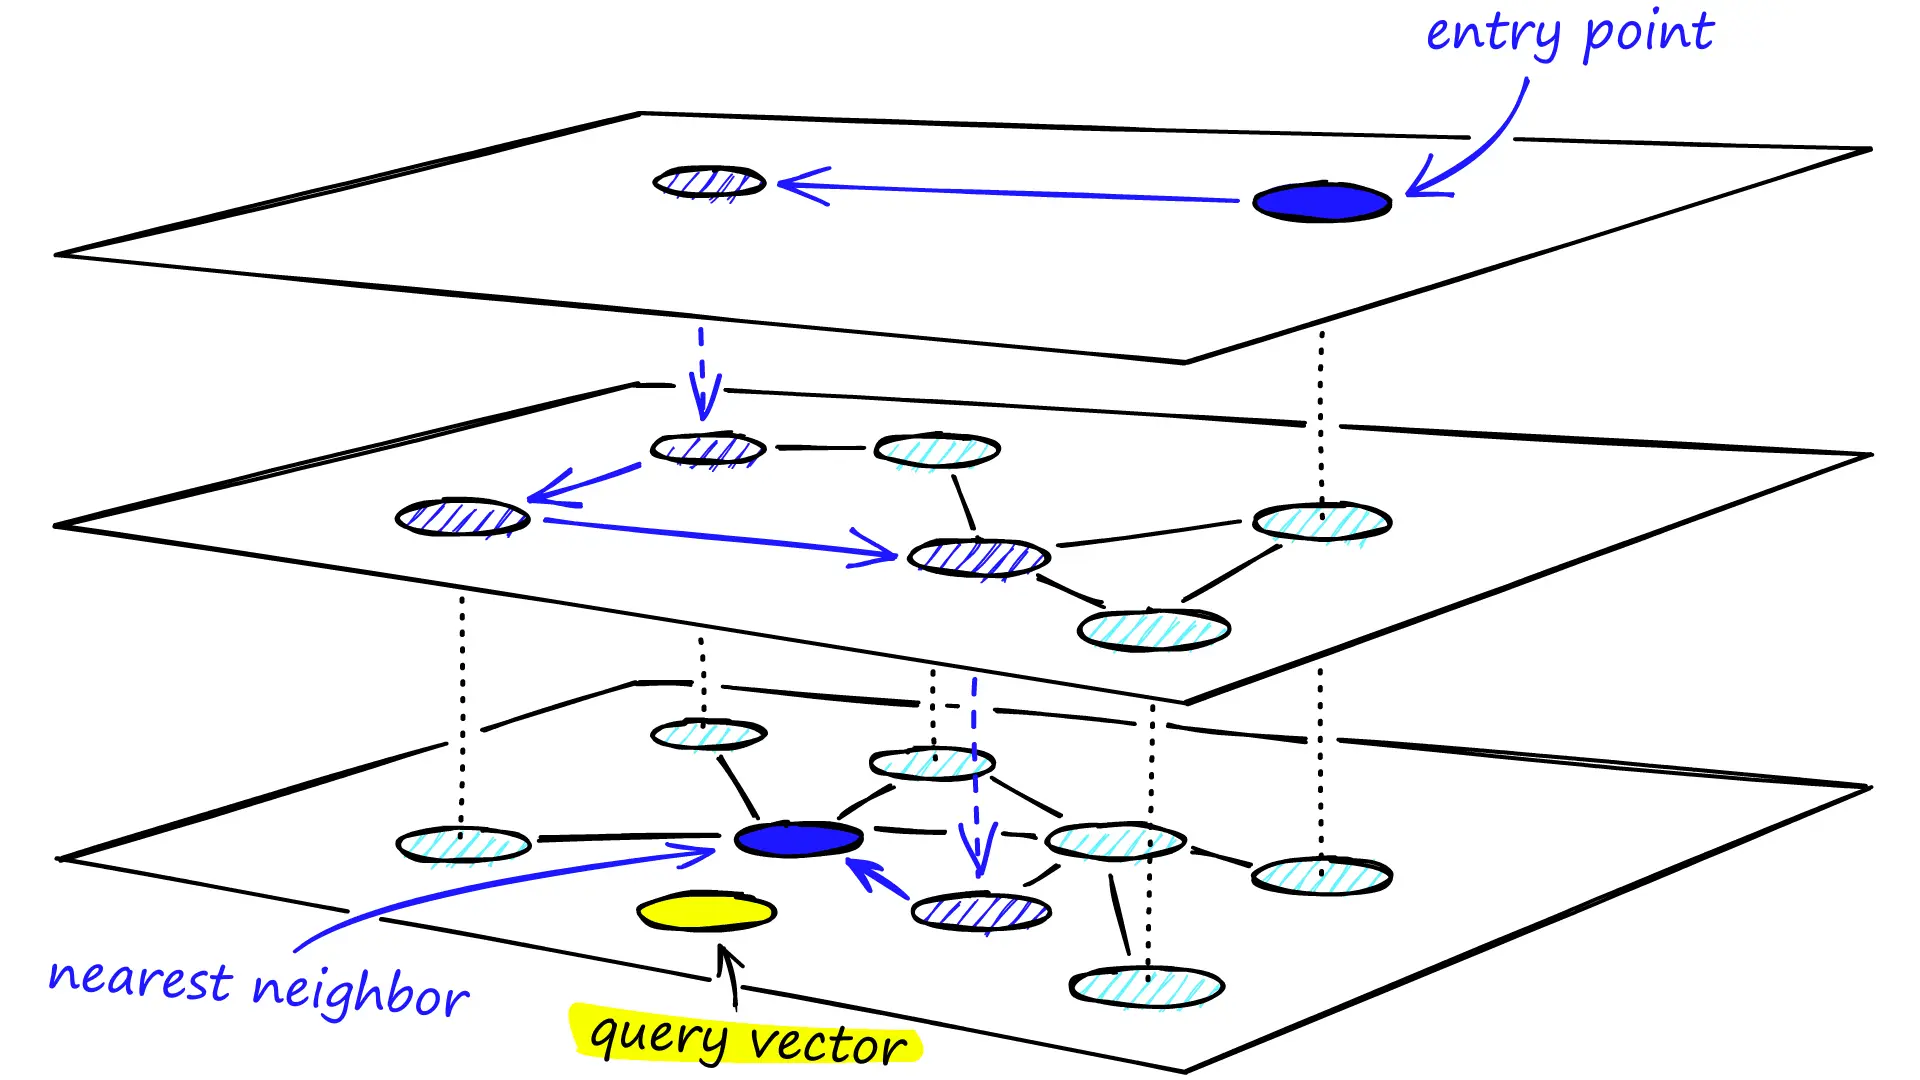

### Complexidade de Busca

Em cada camada, o número esperado de passos antes de encontrar o elemento mais próximo é limitado por uma constante, independente do tamanho do dataset.

A probabilidade de avançar, de acordo com o paper, para o próximo nó que pertence à camada superior é:

$$
p = e^{-mL}
$$

O número esperado de passos em cada camada é:

$$
S = \frac{1}{1 - e^{-mL}}
$$

Se considerarmos que cada nó tem em média C conexões, o número de avaliações de distância por camada é:

$$
Distâncias por camada = C \cdot S
$$

Como o número médio de camadas cresce como (O(log N)), a complexidade seria
$$
O(C \cdot S \cdot log N) => O(log N)
$$

por que sao constantes o C e S. No paper fala que tentam aproximar o grafo gerado ao grafo de Delaunay para que a busca seja em O(log N)

### Complexidade de Construção

A construção do HNSW é feita iterativamente, inserindo um elemento de cada vez. Cada inserção consiste em:

  i)Sequência de buscas K-NN nas diferentes camadas
  
  ii) Aplicação de heurística para selecionar vizinhos

O número médio de camadas por elemento é uma constante que depende de \(mL\). Portanto, o tempo médio de inserção de um elemento tem a mesma complexidade da busca.

Como inserimos \(N\) elementos, entao :

$$
O(N \cdot \log N)
$$


## IMPLEMENTAÇÃO

In [ ]:
class HNSW:
    def __init__(self, M=16, ef_construction=200, ef_search=50):
        self.M = M
        self.ef_construction = ef_construction
        self.ef_search = ef_search

        self.max_level = 0
        self.entry_point = None

        self.graphs = {0: {}}  

        self.vectors = []
        self.levels = []      

    def insert(self, vec):
        new_id = len(self.vectors)
        self.vectors.append(vec)
        self.graphs[0][new_id] = []

        level = int(np.floor(-np.log(np.random.random()) * 1.0))
        self.levels.append(level)

        for l in range(self.max_level + 1, level + 1):
            self.graphs[l] = {}

        if self.entry_point is None:
            self.entry_point = new_id
            self.max_level = level
            for l in range(level + 1):
                self.graphs[l][new_id] = []
            return

        for l in range(level + 1):
            self.graphs[l][new_id] = []

        ep = self.entry_point

        if level < self.max_level:
            for layer in range(self.max_level, level, -1):
                W = self.search_layer(vec, ep, layer, ef=1)
                best = min(W)
                ep = best[1]

        for layer in range(min(self.max_level, level), -1, -1):
            W = self.search_layer(vec, ep, layer, ef=self.ef_construction)
            candidates_ids = [nid for (_, nid) in W]

            neighbors = self.select_neighbors_heuristic(vec, candidates_ids, self.M, layer)

            for nb in neighbors:
                if self.levels[nb] >= layer:
                    self.graphs[layer][new_id].append(nb)
                    self.graphs[layer][nb].append(new_id)

                if len(self.graphs[layer][nb]) > self.M:
                    pruned = self.select_neighbors_heuristic( self.vectors[nb], self.graphs[layer][nb], self.M,layer, extendCandidates=False)
                    self.graphs[layer][nb] = pruned

            ep = min(W)[1]

        if level > self.max_level:
            self.entry_point = new_id
            self.max_level = level

    
    def search_layer(self, q_vec, entry_id, layer, ef) -> List[tuple]:
        visited = set()

        candidates = []     # max-heap, max-heap apenas usando valores negativos no python
        top_results = []    # min-heap

        dist_ep = self.dist(q_vec, self.vectors[entry_id])

        heapq.heappush(candidates, (-dist_ep, entry_id))  
        heapq.heappush(top_results, (dist_ep, entry_id))
        
        visited.add(entry_id)

        while candidates:
            c_dist, c_id = candidates[0]
        
            worst_top_dist = max(top_results)[0] if len(top_results) > 1 else top_results[0][0]

            if -1 * c_dist > worst_top_dist:
                break

            _, c_id = heapq.heappop(candidates)

            for nb in self.graphs[layer][c_id]:
                if nb not in visited:
                    visited.add(nb)
                    dist_nb = self.dist(q_vec, self.vectors[nb])

                    if len(top_results) < ef or dist_nb < worst_top_dist:
                        heapq.heappush(candidates, (-dist_nb, nb))
                        heapq.heappush(top_results, (dist_nb, nb))

                        if len(top_results) > ef:
                            top_results.remove(max(top_results))
                            heapq.heapify(top_results)

        return top_results
    
    def select_neighbors_heuristic(self, q_vec, C, M, layer, extendCandidates=True, keepPrunedConnections=False):

        R = []
        W = []

        for c_id in C:
            d = self.dist(q_vec, self.vectors[c_id])
            heapq.heappush(W, (d, c_id))

        if extendCandidates:
            added = set(C)
            for c_id in C:
                for nb in self.graphs[layer][c_id]:
                    if nb not in added:
                        added.add(nb)
                        d = self.dist(q_vec, self.vectors[nb])
                        heapq.heappush(W, (d, nb))

        Wd = []

        while W and len(R) < M:
            dist_e, e = heapq.heappop(W)

            redundant = False
            for r in R:
                if self.dist(self.vectors[r], self.vectors[e]) < dist_e:
                    redundant = True
                    break

            if not redundant:
                R.append(e)
            else:
                heapq.heappush(Wd, (dist_e, e))

        if keepPrunedConnections:
            while Wd and len(R) < M:
                _, e = heapq.heappop(Wd)
                R.append(e)

        return R
        
    def search(self, q_vec, k=5):            
        
        ep = self.entry_point
        
        for layer in range(self.max_level, 0, -1):
            top_results = self.search_layer(q_vec, ep, layer, ef = 1)
            
            best = min(top_results)
            ep = best[1]
        
        top_results = self.search_layer(q_vec, ep, 0, ef = self.ef_search)
        top_k_results = sorted(top_results)[:k]
    
        return [idx for _, idx in top_k_results]
        
    def dist(self, u, v):
        return np.linalg.norm(u - v)

In [32]:
def plot_hnsw(hnsw):
    vectors = np.array(hnsw.vectors)
    max_level = hnsw.max_level

    fig, axes = plt.subplots(1, max_level + 1, figsize=(5 * (max_level + 1), 5))

    if max_level == 0:
        axes = [axes]

    point_levels = hnsw.levels  

    for level in range(max_level + 1):
        ax = axes[level]
        ax.set_title(f"Nível {level}")

        mask = [i for i, lvl in enumerate(point_levels) if lvl >= level]
        level_vectors = vectors[mask]

        ax.scatter(level_vectors[:, 0], level_vectors[:, 1], c="blue", s=20)

        if level in hnsw.graphs:
            for i in hnsw.graphs[level]:
                for j in hnsw.graphs[level][i]:
                    x = [vectors[i, 0], vectors[j, 0]]
                    y = [vectors[i, 1], vectors[j, 1]]
                    ax.plot(x, y, "gray", linewidth=0.8, alpha=0.7)

                ax.text(vectors[i, 0], vectors[i, 1], str(i), fontsize=8)

        ax.set_aspect("equal")

    plt.tight_layout()
    plt.show()


In [12]:
data = np.random.rand(300, 2)  
h = HNSW(M=4, ef_construction=30)
for v in data:
    h.insert(v)

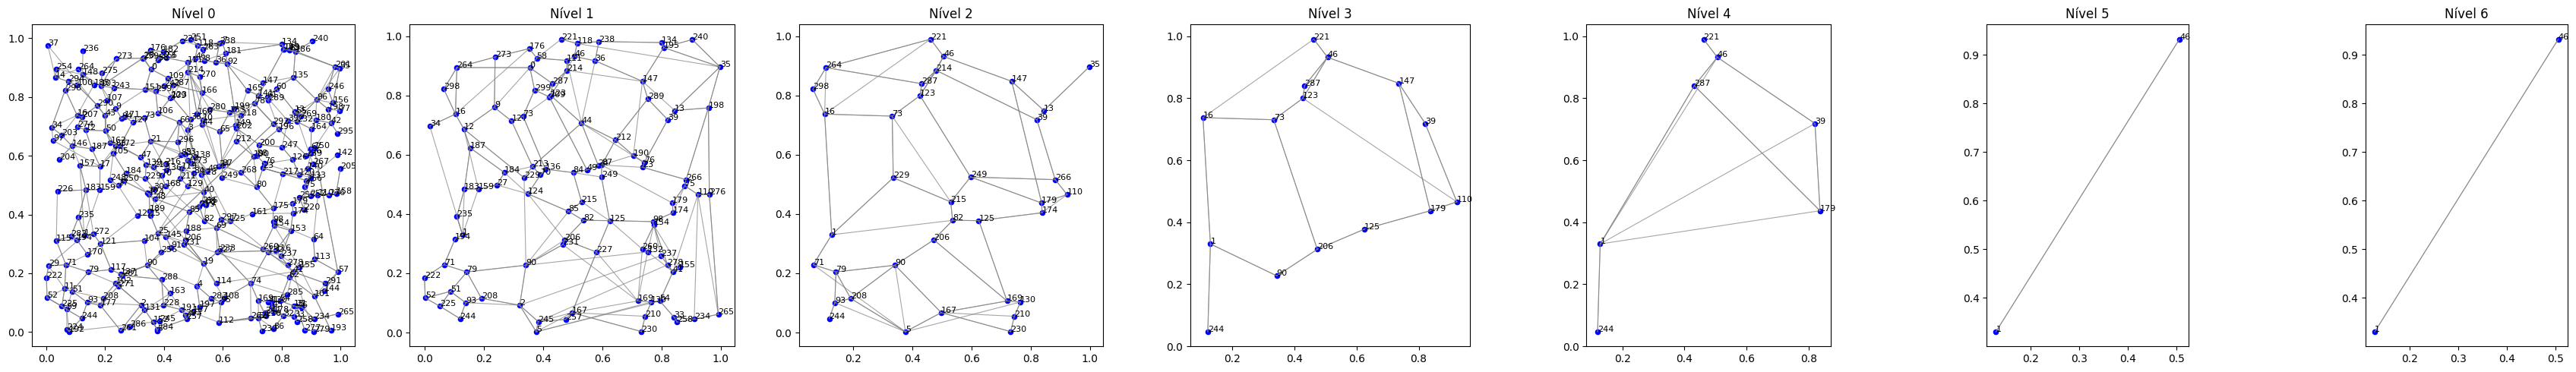

In [13]:
plot_hnsw(h)

In [38]:
def benchmark_HNSW(
    path=r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data",
    N=10000,
    M=12,
    ef_construction=30,
    ef_search=50,
    k=5,
    num_queries=20,
):
    print(f"\n=== Benchmark HNSW: {N:,} embeddings, M={M}, efC={ef_construction}, efS={ef_search} ===")

    print("Carregando embeddings...")
    t0 = time.time()
    subset = make_subset_fast(path, N)
    print(f"Tempo carregamento: {time.time() - t0:.2f} s")
    knn = NaiveKNN(k=k)
    hnsw = HNSW(M=M, ef_construction=ef_construction, ef_search=ef_search)

    print("Construindo HNSW...")
    t0 = time.time()
    for vec in subset:
        hnsw.insert(vec)
    build_time = time.time() - t0

    print(f"Tempo construção do HNSW: {build_time:.2f} s")

    all_degrees = []
    for level in hnsw.graphs:
        for node in hnsw.graphs[level]:
            all_degrees.append(len(hnsw.graphs[level][node]))

    avg_deg = np.mean(all_degrees) if all_degrees else 0
    min_deg = np.min(all_degrees) if all_degrees else 0
    max_deg = np.max(all_degrees) if all_degrees else 0

    print("\n--- Estatísticas dos graus ---")
    print(f"Total de conexões: {len(all_degrees):,}")
    print(f"Grau médio: {avg_deg:.2f}")
    print(f"Grau mínimo: {min_deg}")
    print(f"Grau máximo: {max_deg}")

    recalls = []
    query_times = []

    print(f"\nExecutando {num_queries} buscas...")
    for _ in range(num_queries):
        qidx = np.random.randint(0, N)
        query = subset[qidx]

        gt = knn.search(query, subset)['knn']

        t0 = time.time()
        retrieved = hnsw.search(query, k=k)
        dt = time.time() - t0

        query_times.append(dt)

        acertos = len(set(gt) & set(retrieved))
        recalls.append(acertos / k)

    avg_recall = np.mean(recalls)
    avg_qtime = np.mean(query_times)
    print("\n===== RESULTADOS =====")
    print(f"M:                 {M}")
    print(f"ef_construction:   {ef_construction}")
    print(f"ef_search:         {ef_search}")
    print(f"\nTempo construção:  {build_time:.2f} s")
    print(f"Tempo médio busca: {avg_qtime*1000:.3f} ms")
    print(f"Recall@{k}:        {avg_recall:.3f}")

    print("\n--- Grafo ---")
    print(f"Grau médio:        {avg_deg:.2f}")
    print(f"Grau mínimo:       {min_deg}")
    print(f"Grau máximo:       {max_deg}")

    return {
        "N": N,
        "M": M,
        "ef_construction": ef_construction,
        "ef_search": ef_search,
        "build_time": build_time,
        "avg_query_time": avg_qtime,
        "avg_recall": avg_recall,
        "avg_degree": avg_deg,
        "min_degree": min_deg,
        "max_degree": max_deg,
    }


In [39]:
benchmark_HNSW()


=== Benchmark HNSW: 10,000 embeddings, M=12, efC=30, efS=50 ===
Carregando embeddings...
Tempo carregamento: 15.31 s
Construindo HNSW...
Tempo construção do HNSW: 63.93 s

--- Estatísticas dos graus ---
Total de conexões: 15,765
Grau médio: 6.43
Grau mínimo: 0
Grau máximo: 12

Executando 20 buscas...

===== RESULTADOS =====
M:                 12
ef_construction:   30
ef_search:         50

Tempo construção:  63.93 s
Tempo médio busca: 1.336 ms
Recall@5:        0.220

--- Grafo ---
Grau médio:        6.43
Grau mínimo:       0
Grau máximo:       12


{'N': 10000,
 'M': 12,
 'ef_construction': 30,
 'ef_search': 50,
 'build_time': 63.92808198928833,
 'avg_query_time': np.float64(0.0013363957405090332),
 'avg_recall': np.float64(0.22000000000000003),
 'avg_degree': np.float64(6.4307009197589595),
 'min_degree': np.int64(0),
 'max_degree': np.int64(12)}

In [40]:
def benchmark_ef_search(path=r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data", ef_values = [15, 30, 60, 90, 120, 150], N=10000, M=12, ef_construction=30, k=5, num_queries=20):

    build_times = []
    avg_query_times = []
    avg_recalls = []

    print("Carregando embeddings...")
    t0 = time.time()
    subset = make_subset_fast(path, N)
    print(f"Tempo carregamento: {time.time() - t0:.2f} s")
    knn = NaiveKNN(k=k)
    
    for ef_search in ef_values:
        print(f"\n=== Benchmark HNSW: ef_search={ef_search} ===")
        hnsw = HNSW(M=M, ef_construction=ef_construction, ef_search=ef_search)
        
        print("Construindo HNSW...")
        t0 = time.time()
        for vec in subset:
            hnsw.insert(vec)
        build_time = time.time() - t0
        build_times.append(build_time)
        print(f"Tempo construção: {build_time:.2f} s")
        
        query_times = []
        recalls = []
        for _ in range(num_queries):
            qidx = np.random.randint(0, N)
            query = subset[qidx]
            gt = knn.search(query, subset)['knn']

            t0 = time.time()
            retrieved = hnsw.search(query, k=k)
            dt = time.time() - t0
            query_times.append(dt)

            acertos = len(set(gt) & set(retrieved))
            recalls.append(acertos / k)

        avg_query_times.append(np.mean(query_times))
        avg_recalls.append(np.mean(recalls))
        print(f"Tempo médio busca: {np.mean(query_times)*1000:.3f} ms | Recall@{k}: {np.mean(recalls):.3f}")

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(ef_values, [t*1000 for t in avg_query_times], marker='o')
    plt.xlabel("ef_search")
    plt.ylabel("Tempo médio busca (ms)")
    plt.title("Tempo médio de busca vs ef_search")
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(ef_values, avg_recalls, marker='o', color='orange')
    plt.xlabel("ef_search")
    plt.ylabel("Recall@k")
    plt.title("Recall@k vs ef_search")
    plt.grid(True)
    


Carregando embeddings...
Tempo carregamento: 14.95 s

=== Benchmark HNSW: ef_search=15 ===
Construindo HNSW...
Tempo construção: 62.29 s
Tempo médio busca: 0.793 ms | Recall@5: 0.260

=== Benchmark HNSW: ef_search=30 ===
Construindo HNSW...
Tempo construção: 65.03 s
Tempo médio busca: 0.988 ms | Recall@5: 0.170

=== Benchmark HNSW: ef_search=60 ===
Construindo HNSW...
Tempo construção: 64.48 s
Tempo médio busca: 1.451 ms | Recall@5: 0.230

=== Benchmark HNSW: ef_search=90 ===
Construindo HNSW...
Tempo construção: 65.18 s
Tempo médio busca: 1.846 ms | Recall@5: 0.280

=== Benchmark HNSW: ef_search=120 ===
Construindo HNSW...
Tempo construção: 63.45 s
Tempo médio busca: 1.934 ms | Recall@5: 0.110

=== Benchmark HNSW: ef_search=150 ===
Construindo HNSW...
Tempo construção: 62.74 s
Tempo médio busca: 2.374 ms | Recall@5: 0.170


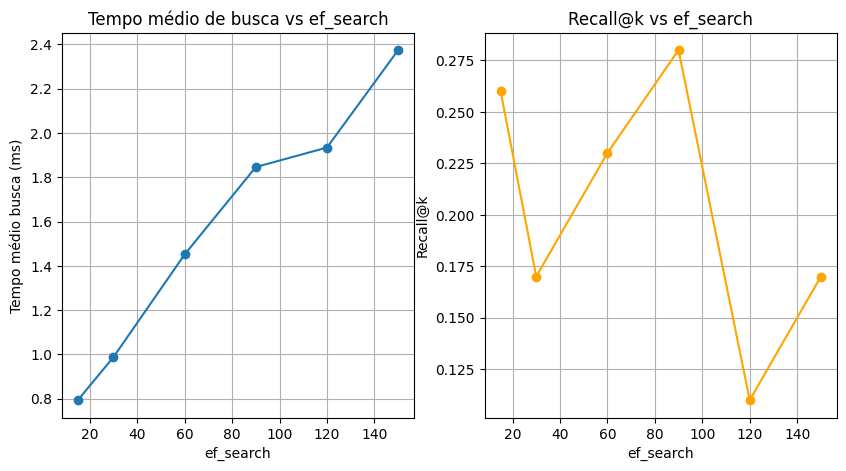

In [41]:
benchmark_ef_search()

Durante a execução dos testes, surgiu uma dúvida sobre a correção da implementação conforme observado na literatura, espera-se que o recall aumente com o aumento do parâmetro ef_search. Uma característica desafiadora tanto do HNSW quanto do LSH é a necessidade de ajustar hiperparâmetros de forma empírica para obter um desempenho ótimo em um conjunto de dados específico. A implementação utilizada segue de forma fiel os pseudocódigos apresentados ao paper. No entanto, pare que posso ter errado em alguma etapa do algoritmo. Cheguei a exata conclusão agora que precisa realmente finetunar os hiperparâmetros e além disso as heuristicas de pegar os melhores candidatos impacta diretamente na construção do grafo.

In [47]:
def benchmark_ef_construction(path=r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data", ef_search = 30, N=10000, M=12, ef_construction=[15, 30, 60, 120], k=5, num_queries=20):

    build_times = []
    avg_query_times = []
    avg_recalls = []

    print("Carregando embeddings...")
    t0 = time.time()
    subset = make_subset_fast(path, N)
    print(f"Tempo carregamento: {time.time() - t0:.2f} s")
    knn = NaiveKNN(k=k)
    
    for ef_c in ef_construction:
        print(f"\n=== Benchmark HNSW: ef_construction={ef_c} ===")
        hnsw = HNSW(M=M, ef_construction=ef_c, ef_search=ef_search)
        
        print("Construindo HNSW...")
        t0 = time.time()
        for vec in subset:
            hnsw.insert(vec)
        build_time = time.time() - t0
        build_times.append(build_time)
        print(f"Tempo construção: {build_time:.2f} s")
        
        query_times = []
        recalls = []
        for _ in range(num_queries):
            qidx = np.random.randint(0, N)
            query = subset[qidx]
            gt = knn.search(query, subset)['knn']

            t0 = time.time()
            retrieved = hnsw.search(query, k=k)
            dt = time.time() - t0
            query_times.append(dt)

            acertos = len(set(gt) & set(retrieved))
            recalls.append(acertos / k)

        avg_query_times.append(np.mean(query_times))
        avg_recalls.append(np.mean(recalls))
        print(f"Tempo médio busca: {np.mean(query_times)*1000:.3f} ms | Recall@{k}: {np.mean(recalls):.3f}")

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(ef_construction, [t*1000 for t in avg_query_times], marker='o')
    plt.xlabel("ef_construction")
    plt.ylabel("Tempo médio busca (ms)")
    plt.title("Tempo médio de busca vs ef_construction")
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(ef_construction, avg_recalls, marker='o', color='orange')
    plt.xlabel("ef_ef_construction")
    plt.ylabel("Recall@k")
    plt.title("Recall@k vs ef_construction")
    plt.grid(True)
    


Carregando embeddings...
Tempo carregamento: 16.46 s

=== Benchmark HNSW: ef_construction=15 ===
Construindo HNSW...
Tempo construção: 37.25 s
Tempo médio busca: 1.168 ms | Recall@5: 0.210

=== Benchmark HNSW: ef_construction=30 ===
Construindo HNSW...
Tempo construção: 63.42 s
Tempo médio busca: 0.960 ms | Recall@5: 0.230

=== Benchmark HNSW: ef_construction=60 ===
Construindo HNSW...
Tempo construção: 112.11 s
Tempo médio busca: 1.127 ms | Recall@5: 0.300

=== Benchmark HNSW: ef_construction=120 ===
Construindo HNSW...
Tempo construção: 196.41 s
Tempo médio busca: 1.141 ms | Recall@5: 0.370


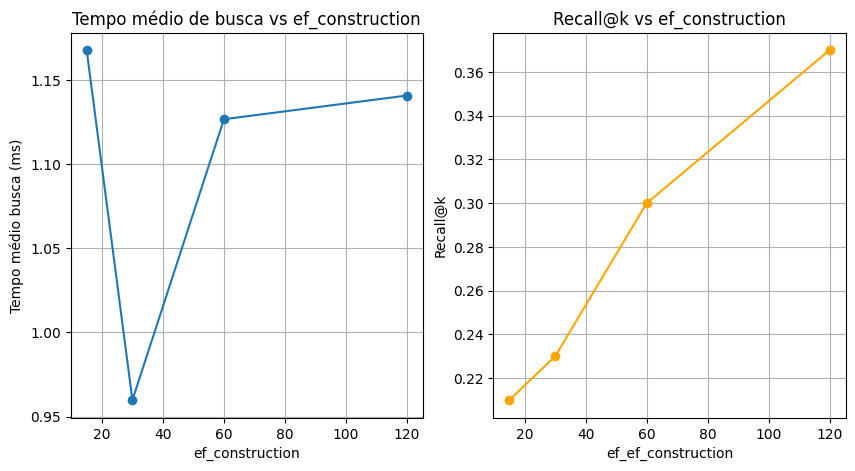

In [48]:
benchmark_ef_construction()

# BENCHMARK


In [49]:

def benchmark_algorithms(path =r"C:\Users\dracb\OneDrive\Documentos\GitHub\RAG4Academia\wikipedia_pt\data", N=100000, k=5, num_queries_list=[100, 500, 1000, 2000]):
    print(f"Carregando {N} embeddings...")
    t0 = time.time()
    subset = make_subset_fast(path, N)
    print(f"Tempo carregamento: {time.time() - t0:.2f} s\n")

    knn = NaiveKNN(k=k)
    lsh = LSH_MultiTable(num_hashes=10, dim=len(subset[0]))
    hnsw = HNSW(M=12, ef_construction=30, ef_search=50)

    print("Construindo LSH...")
    t0 = time.time()
    lsh.add_embeddings(subset)
    build_time_lsh = time.time() - t0
    print(f"Tempo construção LSH: {build_time_lsh:.2f} s\n")
    
    print("Construindo HNSW...")
    t0 = time.time()
    for vec in subset:
        hnsw.insert(vec)
    build_time_hnsw = time.time() - t0
    print(f"Tempo construção HNSW: {build_time_hnsw:.2f} s\n")


    results = {"NaiveKNN": [], "LSH": [], "HNSW": []}

    for num_queries in num_queries_list:
        print(f"\n=== Benchmark com {num_queries} consultas ===")
        queries = [subset[np.random.randint(0, N)] for _ in range(num_queries)]
        
        t0 = time.time()
        for q in queries:
            knn.search(q, subset)
        dt_knn = (time.time() - t0) / num_queries
        results["NaiveKNN"].append(dt_knn)
        print(f"NaiveKNN tempo médio: {dt_knn*1000:.3f} ms")

        t0 = time.time()
        for q in queries:
            lsh.search(q, subset, k=k)
        dt_lsh = (time.time() - t0) / num_queries
        results["LSH"].append(dt_lsh)
        print(f"LSH tempo médio: {dt_lsh*1000:.3f} ms")

        t0 = time.time()
        for q in queries:
            hnsw.search(q, k=k)
        dt_hnsw = (time.time() - t0) / num_queries
        results["HNSW"].append(dt_hnsw)
        print(f"HNSW tempo médio: {dt_hnsw*1000:.3f} ms")

    plt.figure(figsize=(10,6))
    for algo in results:
        plt.plot(num_queries_list, np.array(results[algo])*1000, marker='o', label=algo)
    plt.xlabel("Número de consultas")
    plt.ylabel("Tempo médio por consulta (ms)")
    plt.title(f"Benchmark de busca KNN - {N} embeddings")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    return results

Carregando 100000 embeddings...
Tempo carregamento: 15.83 s

Construindo LSH...
Tempo construção LSH: 2.59 s

Construindo HNSW...
Tempo construção HNSW: 772.88 s


=== Benchmark com 100 consultas ===
NaiveKNN tempo médio: 596.006 ms
LSH tempo médio: 13.910 ms
HNSW tempo médio: 1.462 ms

=== Benchmark com 500 consultas ===
NaiveKNN tempo médio: 614.890 ms
LSH tempo médio: 13.754 ms
HNSW tempo médio: 1.530 ms

=== Benchmark com 1000 consultas ===
NaiveKNN tempo médio: 617.376 ms
LSH tempo médio: 14.132 ms
HNSW tempo médio: 1.440 ms

=== Benchmark com 2000 consultas ===
NaiveKNN tempo médio: 661.845 ms
LSH tempo médio: 16.200 ms
HNSW tempo médio: 1.701 ms


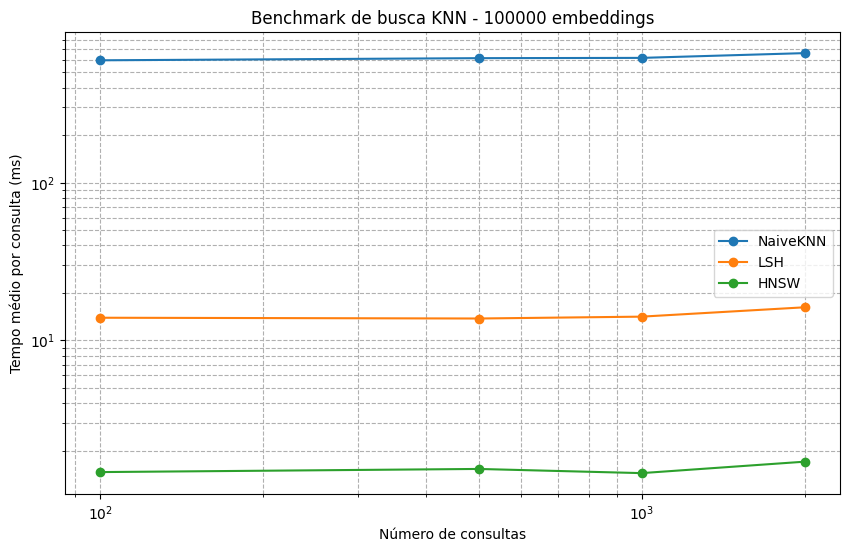

{'NaiveKNN': [0.5960063934326172,
  0.6148902902603149,
  0.6173762710094451,
  0.6618450857400894],
 'LSH': [0.013910088539123535,
  0.013753600120544433,
  0.01413211727142334,
  0.016199878454208373],
 'HNSW': [0.0014617037773132324,
  0.0015302610397338867,
  0.0014397404193878173,
  0.0017013758420944213]}

In [50]:
benchmark_algorithms()

Por se tratar de uma implementação não totalmente otimizada, especialmente no caso do HNSW cuja construção em Python tende a ser naturalmente lenta foi necessário reduzir o conjunto para 10 mil embeddings. Ainda assim, os resultados obtidos são suficientes para revelar o comportamento esperado de cada algoritmo.

O KNN ingênuo apresentou o maior tempo de consulta, já que opera em complexidade O(N), realizando uma comparação direta com todos os vetores do conjunto. O LSH, por sua vez, obteve um ganho considerável de desempenho, refletindo sua natureza sublinear e sua capacidade de reduzir a busca para um conjunto muito menor de candidatos.

O HNSW demonstrou excelente velocidade de consulta, superando com folga os demais algoritmos para múltiplas buscas. Seu ponto fraco, entretanto, permanece na etapa de construção da estrutura  mais custosa e com complexidade aproximadamente O(N log N) conforme descrito no artigo original o que explica o tempo mais elevado de indexação observado nos experimentos.